In [32]:
#Збір даних → 
# 2. Передобробка → 
# 3. Розділення на train/val/test → 
# 4. Побудова фіч → 
# 5. Навчання моделі → 
# 6. Оцінка й аналіз помилок → 
# 7. Розгортання (API/пакет) → 
# 8. Моніторинг і ретренінг.

In [2]:
from datasets import load_dataset
from datasets import Dataset

import os, sys
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, pipeline

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


C:\Users\Denys\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
dir_path = os.getcwd()

ds = load_dataset("YShynkarov/COSMUS")

In [5]:
labels = ["positive","negative","neutral"]


In [6]:
df = ds["train"].to_pandas()

only_ukrainian_df_no_null = df[
    df["stratification_label"].notnull() &
    (df["stratification_label"].astype(str).str.strip() != "")
]

# Only UKR text in use
only_ukrainian_df_draft = only_ukrainian_df_no_null[only_ukrainian_df_no_null["language"] == "ua"]


only_ukrainian_df = only_ukrainian_df_draft.reset_index(drop=True)

only_ukrainian_df["stratification_label"] = only_ukrainian_df["stratification_label"].map({"neutral_ua": labels.index("neutral"), 
                                                                                           "positive_ua": labels.index("positive"), 
                                                                                           "negative_ua": labels.index("negative")})


only_ukrainian_df["old_gpt_labels"] = only_ukrainian_df["gpt_labels_v1"]

only_ukrainian_df["gpt_labels_v1"] =  only_ukrainian_df["gpt_labels_v1"].map({"neutral": labels.index("neutral"),
                                                                                    "positive": labels.index("positive"), 
                                                                                    "negative": labels.index("negative")})



print(only_ukrainian_df.head())
#only_ukrainian_df.info()


   response_id  document_id     user_id annotator_sentiment  is_ck_annotation  \
0            1            1   277133851             neutral                 1   
1            3            2  1065283664             neutral                 1   
2            6            5  1065283664             neutral                 1   
3            7            6  1065283664            positive                 1   
4            8            7  1065283664             neutral                 1   

           response_timestamp  \
0  2025-03-09T23:23:07.220881   
1  2025-03-09T23:44:28.262307   
2  2025-03-09T23:46:38.993496   
3  2025-03-09T23:46:44.525849   
4  2025-03-09T23:46:56.995087   

                                    document_content annotation_date username  \
0  ⚡️Українська делегація відправилася на перемов...      2025-03-09        O   
1               Вибухи на Одещині, попередньо — ППО.      2025-03-09        A   
2                                        Добрий день      2025-03-09   

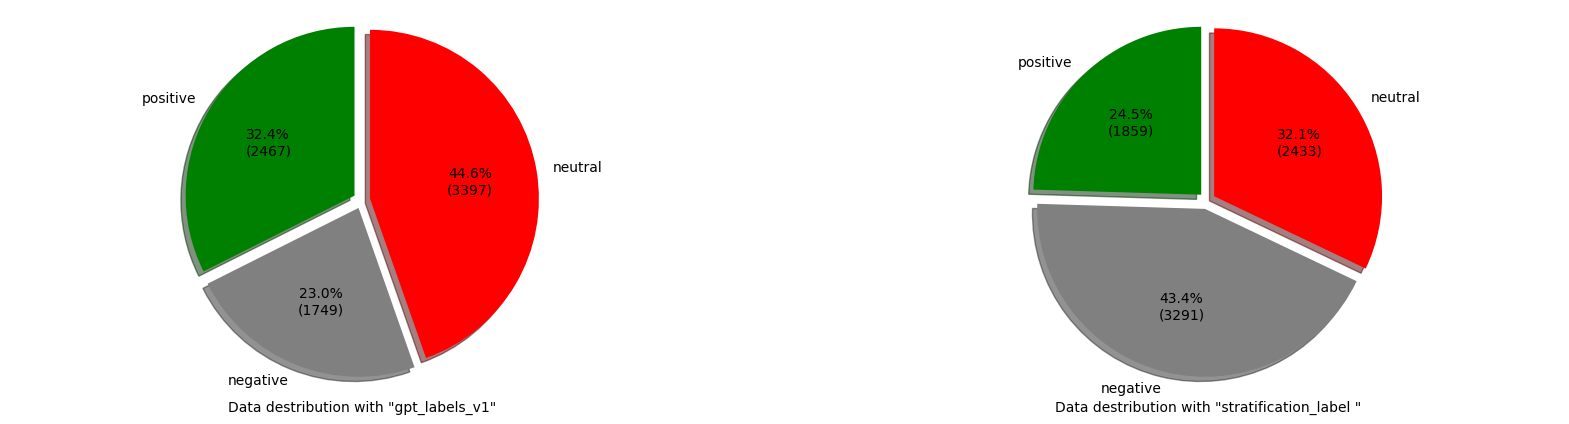

In [10]:
#1.2 Data destribution with grafic or pie chart

def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

positive_amount = only_ukrainian_df[only_ukrainian_df["gpt_labels_v1"] == labels.index("positive")]
neutral_amount  = only_ukrainian_df[only_ukrainian_df["gpt_labels_v1"] == labels.index("neutral")]
negative_amount = only_ukrainian_df[only_ukrainian_df["gpt_labels_v1"] == labels.index("negative")]

#labels = ['positive', 'neutral', 'negative']
sizes = [len(positive_amount), len(neutral_amount), len(negative_amount),]
colors = ['green','grey', "red"]
explode = (0.05, 0.05, 0.05)

axes[0].pie(sizes, labels=labels, colors=colors, 
        autopct= lambda pct: autopct_format(pct, sizes),
        startangle=90, explode=explode, shadow=True)

axes[0].set_xlabel('Data destribution with "gpt_labels_v1"')
axes[0].axis('equal')

positive_amount = only_ukrainian_df[only_ukrainian_df["stratification_label"] == labels.index("positive")]
neutral_amount  = only_ukrainian_df[only_ukrainian_df["stratification_label"] == labels.index("neutral")]
negative_amount = only_ukrainian_df[only_ukrainian_df["stratification_label"] == labels.index("negative")]

#labels = ['positive', 'neutral', 'negative']
sizes = [len(positive_amount), len(neutral_amount), len(negative_amount),]
colors = ['green','grey', "red"]
explode = (0.05, 0.05, 0.05)

axes[1].pie(sizes, labels=labels, colors=colors, 
        autopct= lambda pct: autopct_format(pct, sizes),
        startangle=90, explode=explode, shadow=True)

axes[1].set_xlabel('Data destribution with "stratification_label "')
axes[1].axis('equal')

plt.show()

In [11]:
# stratification_label
#Коли ти вказуєш, що треба стратифікувати за label, алгоритм під час розбиття гарантує:
#train, val і test мають такі самі пропорції класів, як і весь датасет.

In [12]:
# 
# how many automatic labels are wrong
wrong_estimation = only_ukrainian_df[only_ukrainian_df["stratification_label"] != only_ukrainian_df["gpt_labels_v1"]]

print("Wrong labels counter: ", len(wrong_estimation))


Wrong labels counter:  3335


In [13]:
# prepare training data 

In [14]:

label2id = {lab:i for i,lab in enumerate(labels)}
id2label = {i:lab for lab,i in label2id.items()}

print(label2id)
print(id2label)


{'positive': 0, 'negative': 1, 'neutral': 2}
{0: 'positive', 1: 'negative', 2: 'neutral'}


In [15]:
# set a pretrained model -> return tourch object
# model = AutoModelForSequenceClassification.from_pretrained(
#     "xlm-roberta-base",
#     num_labels=len(labels),
#     num_labels=1,
#     id2label=id2label,
#     label2id=label2id
# )

model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=1,
    problem_type="regression"
)

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:


#tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", add_prefix_space=True)

enc = tokenizer("Мені дуже сумно сьогодні", padding="max_length", truncation=True, max_length=8, return_tensors="pt")

print(enc)

{'input_ids': tensor([[     0, 141203,  13753,   9439,    380,  33158,      2,      1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0]])}


In [17]:
#Підготовка датасету Hugging Face

# {
#   'text': 'Мені дуже подобається цей день!',
#   'label': 'joy',
#   'label_id': 0,
#   'input_ids': [0, 43216, 10123, 2540, 278, 345, 2, 1, 1, 1, 1, ...],
#   'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...]
# }


def create_proper_labels(number):
    pass
    


dataset = pd.DataFrame({
    "text": only_ukrainian_df["document_content"],
    "labels": only_ukrainian_df["gpt_labels_v1"],
    #"labels": only_ukrainian_df["old_gpt_labels"],
    #'input_ids_attention_mask': tokenizer(only_ukrainian_df["document_content"], padding="max_length", truncation=True, max_length=8),
})

# tokinase all at once together 
tokenized = tokenizer(
    list(dataset["text"]),        # тексти
    max_length=128,               # бажана довжина (можеш змінити)
    return_tensors=None,           # повертає звичайні списки (для pandas)
    padding="max_length", 
    truncation=True
)



dataset["input_ids"] = tokenized["input_ids"]
dataset["attention_mask"] = tokenized["attention_mask"]

#dataset["labels"] = dataset["labels"].astype(int)

#only_ukrainian_df_no_null = df[df["stratification_label"].notnull()]

#test_1 = dataset[dataset[type(dataset["labels"]) != int]

dataset_no_null = dataset[dataset["labels"].notnull()]
dataset_no_null = dataset_no_null.reset_index(drop=True)

print(dataset_no_null.head())

# HuggingFace Dataset
tokenized_dataset = Dataset.from_pandas(dataset_no_null)


                                                text  labels  \
0  ⚡️Українська делегація відправилася на перемов...     2.0   
1               Вибухи на Одещині, попередньо — ППО.     1.0   
2                                        Добрий день     2.0   
3               Бажаю удачі тим, хто цього потребує.     0.0   
4  Під Бахмутом українські військові просунулися ...     0.0   

                                           input_ids  \
0  [0, 6, 244754, 15755, 61684, 59, 15126, 680, 1...   
1  [0, 2857, 96092, 89, 29, 7459, 103, 59746, 4, ...   
2  [0, 184411, 312, 6365, 2, 1, 1, 1, 1, 1, 1, 1,...   
3  [0, 5758, 3735, 743, 120613, 260, 10719, 4, 11...   
4  [0, 20434, 136100, 1719, 13449, 110732, 201665...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...  
4  

In [18]:
# Ділимо train/test
train_test_dataset = tokenized_dataset.train_test_split(test_size=0.2)

In [38]:
# -------------------------
# 5. Налаштування тренування
# -------------------------
training_args = TrainingArguments(
    #output_dir="./emotion_model",
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=0.7,
    weight_decay=0.01,
    logging_steps=10,
    logging_dir="./logs"
)


def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted")
    }


# Конвертуємо labels у int (на випадок, якщо Dataset зберіг тип object)
#train_dataset = train_test_dataset["train"].map(lambda x: {"labels": int(x["labels"])})
#val_dataset = train_test_dataset["test"].map(lambda x: {"labels": int(x["labels"])})


train_dataset =  train_test_dataset["train"]
val_dataset = train_test_dataset["test"]


In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\Denys\AppData\Local\Temp\ipykernel_5336\2721217396.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
batch = train_dataset[:8]  # беремо перші 8 прикладів
inputs = {
    "input_ids": batch["input_ids"],
    "attention_mask": batch["attention_mask"],
    "labels": batch["labels"],
}

import torch
inputs = {k: torch.tensor(v) for k, v in inputs.items()}

print(inputs["input_ids"])


----> 1.0
tensor([[     0,   1813,   2401,  ...,      1,      1,      1],
        [     0,   1509, 177327,  ...,      1,      1,      1],
        [     0,   4910,  74307,  ...,      1,      1,      1],
        ...,
        [     0,   1089,  23774,  ...,      1,      1,      1],
        [     0, 111675,  12553,  ...,      1,      1,      1],
        [     0,   1089,      4,  ...,      1,      1,      1]])


In [41]:
trainer.train()

C:\Users\Denys\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.474300
20,0.427200
30,0.304300
40,0.367400
50,0.331000
60,0.425300
70,0.399400
80,0.372200
90,0.361800
100,0.245200


TrainOutput(global_step=534, training_loss=0.31751412845282967, metrics={'train_runtime': 2436.1348, 'train_samples_per_second': 1.75, 'train_steps_per_second': 0.219, 'total_flos': 281000084115456.0, 'train_loss': 0.31751412845282967, 'epoch': 0.7007874015748031})

In [ ]:
trainer.save_model("emotion_model_final")
tokenizer.save_pretrained("emotion_model_final")

In [42]:
logs = pd.DataFrame(trainer.state.log_history)
logs.head()

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4743,10.047225,0.000020,0.013123,10,NaN,NaN,NaN,NaN,NaN
1,0.4272,12.912915,0.000019,0.026247,20,NaN,NaN,NaN,NaN,NaN
2,0.3043,18.593584,0.000019,0.039370,30,NaN,NaN,NaN,NaN,NaN
3,0.3674,7.171600,0.000019,0.052493,40,NaN,NaN,NaN,NaN,NaN
4,0.3310,23.166279,0.000018,0.065617,50,NaN,NaN,NaN,NaN,NaN


In [19]:
plt.plot(logs["step"], logs["loss"], label="Training loss")
#plt.plot(logs["step"], logs["training_loss"], label="Validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

NameError: name 'logs' is not defined

In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(fr"{dir_path}\emotion_model\checkpoint-534")
tokenizer = AutoTokenizer.from_pretrained(fr"{dir_path}\emotion_model\checkpoint-534")

label2id = {lab:i for i,lab in enumerate(labels)}
id2label = {i:lab for lab,i in label2id.items()}

model.config.id2label = id2label
model.config.label2id = label2id

In [31]:
from transformers import pipeline

clf = pipeline("text-classification", model=model, tokenizer=tokenizer)
#result = clf("Мені сьогодні дуже сумно, бо поганий день 😞")
#result = clf("Мені сьогодні дуже радісно, гарний день :)")

texts = [
    "Я дуже радий цьому!",
    "Мені страшно за майбутнє.",
    "Це найгірший день у моєму житті."
]
results = clf(texts)

print(results)

Device set to use cpu


[{'label': 'positive', 'score': -0.05553281679749489}, {'label': 'positive', 'score': 0.9275057315826416}, {'label': 'positive', 'score': 0.7890942692756653}]
